In [1]:
import sys
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import Markdown
from os import listdir
from os.path import exists
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

In [2]:
def get_pca(hidden, hidden_data_path):
    pca = pd.DataFrame()
    
    print("Start to calculate the PCA of each hidden layer.")
    for i in tqdm(hidden):
        X = pd.read_csv(
            hidden_data_path + i,
            sep=" ",
            header=None,
        )

        X_pca = PCA(n_components=1).fit_transform(X)
        pca = pd.concat([
            pca, 
            pd.DataFrame(X_pca)
        ], axis=1)

    pca.columns = [i.split('.')[0] for i in hidden]

    return pca

In [3]:
def get_figure(PREFIX, tmp_pos, pubchem_id):
    plt.bar(
        list(tmp_pos.index)[:10],
        tmp_pos[0][:10]
    )
    plt.xticks(rotation=45)
    plt.xlabel('Top 10 GO terms')
    plt.ylabel('PC1 score')
    plt.savefig('./{}_top10_{}.png'.format(PREFIX, pubchem_id))
    plt.show()
    
    plt.bar(
        list(tmp_pos.index)[-10:],
        tmp_pos[0][-10:]
    )
    plt.xticks(rotation=45)
    plt.xlabel('Bottom 10 GO terms')
    plt.ylabel('PC1 score')
    plt.savefig('./{}_bottom10_{}.png'.format(PREFIX, pubchem_id))
    plt.show()

In [4]:
def get_importance(
        hidden_data_path, 
        test, 
        SMILES_PubchemID_table_data_path,
        pubchem_id
    ):
    hidden = listdir(hidden_data_path)
    hidden = [i for i in hidden if "GO" in i]
    
    GO_terms = get_pca(hidden, hidden_data_path)
    pubchem = pd.read_csv(
        SMILES_PubchemID_table_data_path,
        header=None,
        sep='\t'
    )
    
    test = pd.read_csv(
        test,
        header=None,
        sep='\t'
    )
    
    tmp = pubchem[pubchem[0] == pubchem_id]
    tmp = test[test[1] == tmp[1].values[0]]
    
    tmp_pos = tmp[tmp[2] > 0] 
    tmp_neg = tmp[tmp[2] < 0] 

    tmp_pos= pd.DataFrame(
        np.mean(GO_terms.loc[list(tmp_pos.index)])
    ).sort_values(0, ascending=False)
     
    tmp_neg = pd.DataFrame(
        np.mean(GO_terms.loc[list(tmp_neg.index)])
    ).sort_values(0, ascending=False)
    
    tmp_pos.to_csv('importance_for_pos_{}.csv'.format(pubchem_id))
    tmp_neg.to_csv('importance_for_neg_{}.csv'.format(pubchem_id))

    get_figure('pos', tmp_pos, pubchem_id)
    get_figure('neg', tmp_neg, pubchem_id)

Start to calculate the PCA of each hidden layer.


100%|██████████| 2086/2086 [13:33<00:00,  2.56it/s]


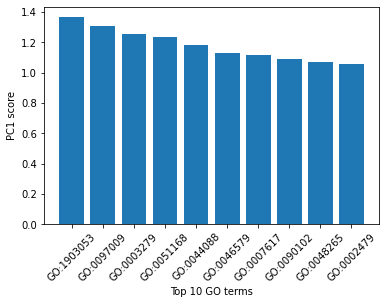

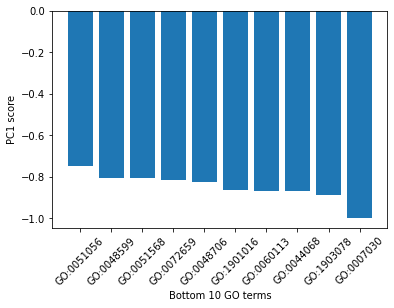

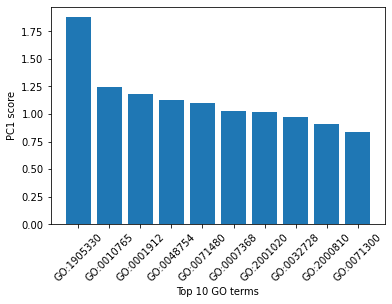

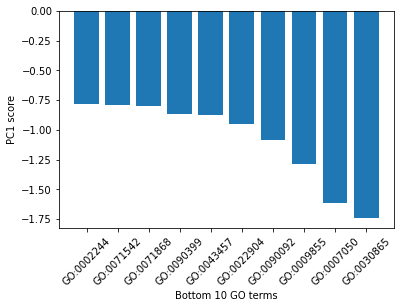

In [5]:
get_importance(
    '/export/scratch/inoue019/Hidden/', 
    '../DrugCell/data_rcellminer/test_rcell_wo_other.txt', 
    '../DrugCell/data_rcellminer/SMILES_from_PubchemID.txt', 
    24360
)